In [2]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import os, sys
import healpy as hp
import numpy as np
from scipy.integrate import quad
import matplotlib.pyplot as plt
from matplotlib import rcParams
from tqdm import *
import iminuit
from iminuit import Minuit, describe, Struct
from scipy.interpolate import interp1d

sys.path.append("/tigress/somalwar/Subhaloes/Subhalos/Modules/")
# My Functions
import AssortedFunctions
from AssortedFunctions import myLog
import InverseTransform
import PointSource
import PowerLaw

# Siddharth and Laura's Stuff
import constants_noh as constants
import units

# NPTFit modules
from NPTFit import nptfit # module for performing scan
from NPTFit import create_mask as cm # module for creating the mask
from NPTFit import psf_correction as pc # module for determining the PSF correction
from NPTFit import dnds_analysis
rcParams['font.size'] = 15
rcParams['text.usetex'] = True

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
trials = 1000
channel = 'b'
Nb = 1
conc = "SP"
xsec = 1e-22
marr = [100]
ebins = [2,20]

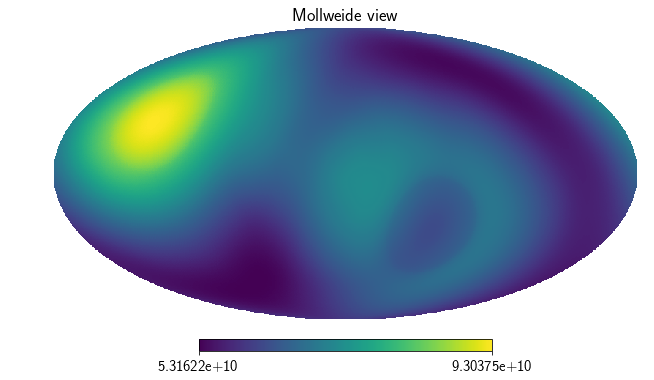

In [4]:
# Setting basic parameters
nside = 128
npix = hp.nside2npix(nside)
   
pscmask=np.array(np.load('fermi_data/fermidata_pscmask.npy'), dtype=bool)
exposure=np.array(np.load('fermi_data/fermidata_exposure.npy'))
mask = cm.make_mask_total(band_mask = True, band_mask_range = 5, mask_ring = True, inner = 20, outer = 180, custom_mask = pscmask)
area_rat = (len(mask[~mask]))/len(mask)
hp.mollview(exposure)

In [5]:
# Defining some constants
r_s = 199 # scale radius, [kpc]
alpha = 0.17 #0.678
N_calib = 300. # Number of subhalos with masses 10^8 - 10^10 M_sun
M_MW = 1.1e12 # [M_s]
mMin_calib = 1e8 # [M_s]
mMax_calib = 1e10 # [M_s]
mMin = 1e-5*M_MW
mMax = .01*M_MW # [M_s]
min_flux = np.log10(1./(np.sum(exposure[~mask])/len(exposure[~mask])))

In [6]:
def dNdm_func(m): # Subhalo mass function
    norm = N_calib / ( -.9**(-1) * (mMax_calib**(-.9) - mMin_calib**(-.9)))
    return norm * (m)**(-1.9)

N_subs = round(N_calib / ( -.9**(-1) * (mMax_calib**(-.9) - mMin_calib**(-.9))) * -.9**(-1) * (mMax**(-.9) - mMin**(-.9))) # Total number of subhalos
N_subs = np.random.poisson(N_subs)
print(N_subs)

m_arr = np.logspace(np.log10(mMin), np.log10(mMax), 8000) # mass values to test
def mCDFInv(r):
    return ( m_arr[0]**(-.9) - (m_arr[0]**(-.9) - m_arr[-1]**(-.9))*r)**(-1/.9)

rho_s2 = float(N_subs) / quad(lambda x: 4 * np.pi * x**2 * np.exp( -2./alpha * ( (x/r_s)**(alpha) - 1)), 0, 2000)[0]
def rho_Ein(r): # Einasto density Profile
    return rho_s2 * np.exp( (-2./alpha) * ( (r/r_s)**(alpha) - 1))

2193


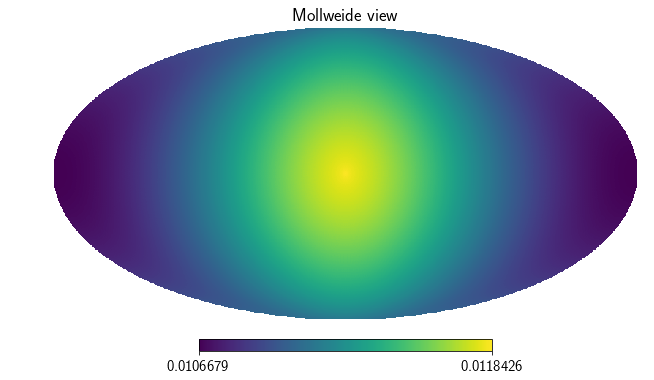

In [7]:
Omegapix = hp.nside2pixarea(nside)
def r_galactocentric(l, psi_deg):
    return np.sqrt(constants.r0**2. + l**2. - 2.*constants.r0*l*np.cos(np.radians(psi_deg)))

def Einasto_integral_LOS(psi_deg):
    return quad(lambda l: l**2 * rho_Ein(r_galactocentric(l, psi_deg)), 0., 2000.)[0]

def make_Einasto_template():
    psi_deg = np.arange(0., 180.5, 0.5)
    integrand_Ein = np.vectorize(Einasto_integral_LOS)(psi_deg)
    Einasto_Int = interp1d(psi_deg, integrand_Ein*Omegapix)
    psi_deg_pixels = np.array([np.degrees(np.arccos(np.dot([1.0, 0.0, 0.0], hp.pix2vec(nside, pix)))) for pix in range(npix)])                                                                 
    return Einasto_Int(psi_deg_pixels)

template = np.nan_to_num(make_Einasto_template())
template = template
hp.mollview(template)
np.save("EinastoTemplate_alpha17", template)

In [8]:
r_arr = np.logspace(0, np.log10(2000), 60500) # radius values to test
r_sampler = InverseTransform.InverseTransform(lambda r: r**2 * rho_Ein(r), r_arr, nsamples=N_subs)
m_sampler = InverseTransform.InverseTransform(dNdm_func, m_arr, nsamples=N_subs, cdfinv=mCDFInv)

In [9]:
PS_arr = []
F_arr = []
flux_bins = np.logspace(-15, -6, 8*8)

for i in tqdm_notebook(range(trials)):
    rval_arr = r_sampler.sample()
    mval_arr = m_sampler.sample()

    theta_arr = (np.arccos(2*np.random.rand(N_subs)-1))
    phi_arr = (2*np.pi*np.random.rand(N_subs))

    PS_set = PointSource.PointSource(mval_arr, rval_arr, theta_arr, phi_arr)
    PS_set.calcJ(conc)
    PS_arr.append(PS_set)
    
    if i == 0: PPnoxsec = PS_set.PPnoxsec(marr[0], ebins, channel)
    F_arr.append(np.histogram(PS_set.J.value[~mask[PS_set.pixels]] * xsec * PPnoxsec, bins=flux_bins)[0])
print(PPnoxsec)

/tigress/somalwar/anaconda3/lib/python3.6/site-packages/scipy/integrate/quadpack.py:385: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  warnings.warn(msg, IntegrationWarning)



2.9786839931645153e-05


In [10]:
min_flux_ind = np.argmin(np.abs(flux_bins - 10.**(min_flux)))
flux_bins2 = flux_bins[min_flux_ind:]
F_arr = np.array(F_arr).astype(float)
for i in range(len(F_arr)):
    F_arr[i][F_arr[i]==0] = 1e-50

F_ave = (np.median(F_arr, axis=0))[min_flux_ind:]
max_flux_ind = np.argmax(F_ave < 1e-20)
max_flux = np.log10(flux_bins2[min_flux_ind])
dF = np.diff(flux_bins2)
dN = np.array(F_ave)/(4*np.pi*(180/np.pi)**2*area_rat)
F = (np.array(flux_bins2)[:-1]+np.array(flux_bins2)[1:])/2.
print(1/(4*np.pi*(180/np.pi)**2*area_rat))

2.9852067389362934e-05


In [12]:
subhalos = np.load('/tigress/somalwar/Subhaloes/Subhalos/MC/EinastoTemplate2.npy')
flux_map_ave = np.zeros(hp.nside2npix(nside))
for iP, PS_set in (enumerate(PS_arr)):
    flux_map = np.zeros(hp.nside2npix(nside))
    flux = PS_set.J.value * xsec * PPnoxsec
    for ipix, pix in enumerate(PS_set.pixels):
        flux_map[pix] += flux[ipix]
    np.save("subhalo_flux_map_1ebin"+str(iP), flux_map)
    if iP == 0: sig = np.round(flux_map * exposure).astype(np.int32)
    flux_map_ave += flux_map
sig = np.round(flux_map_ave/trials * exposure).astype(np.int32)
n = nptfit.NPTF(tag='fit')
n.load_data(sig, exposure)
n.load_mask(mask)

A0 = 5.45252e-06
n20 = 1.45582
n10 = 10.0
Fb0 = 10**(-7.71429)*np.average(exposure[~mask])

subhalos_copy = subhalos.copy()
n.add_template(subhalos_copy, 'subhalos', units='PS')
n.add_non_poiss_model('subhalos', 
                       ['$A^\mathrm{ps}_\mathrm{iso}$','$n_1$','$n_2$','$F_b$'],
                          units='counts')
n.configure_for_scan(nexp=20);

minuit_min = iminuit.Minuit(lambda A, n1, n2, Fb: -n.ll([A, n1, n2, Fb]), n1=n10, Fb=Fb0, fix_n1=True, fix_Fb=True, fix_A=False, fix_n2=False, A=A0, limit_A=(1e-15, 1), error_A=1e-15, n2=n20, limit_n2=(-3.,3.), error_n2=1e-2, print_level=1);
minuit_min.migrad()
max_LL = -minuit_min.fval
best_fit_params = ( np.array( [minuit_min.values['A'], minuit_min.values['n1'], minuit_min.values['n2'], minuit_min.values['Fb'] ]))
best_fit_params = np.array(best_fit_params*np.array([np.average(exposure[~mask]/area_rat/(4*np.pi * (180/np.pi)**2)*np.sum(subhalos[~mask])), 1., 1., 1/np.average(exposure[~mask])]))
best_fit_params[0] = np.log10(best_fit_params[0])
best_fit_params[3] = np.log10(best_fit_params[3])
print("Best Fit Params:", best_fit_params)
print("Max LL:", max_LL)

The number of parameters to be fit is 4


/tigress/somalwar/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:28: InitialParamWarning: errordef is not given. Default to 1.


FCN = 28342.148822268744 
 TOTAL NCALL = 90 
 NCALLS = 90 
 
 
 EDM = 1.9892663293676224e-06 
 GOAL EDM = 1e-05 
 
 UP = 1.0 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,A,1.50326e-06,1.33038e-07,0,0,1e-15,1.0,
2,n1,10,1,0,0,,,FIXED
3,n2,1.78913,0.0079579,0,0,-3.0,3.0,
4,Fb,1264.28,1,0,0,,,FIXED


Best Fit Params: [ 3.72450575 10.          1.78913363 -7.71429   ]
Max LL: -28342.148822268744


In [13]:
print(max_flux)

-6.714285714285715


/tigress/somalwar/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: InitialParamWarning: errordef is not given. Default to 1.
  """Entry point for launching an IPython kernel.


FCN = 1.357914437144741e+27 
 TOTAL NCALL = 81 
 NCALLS = 81 
 
 
 EDM = 12960526486074.795 
 GOAL EDM = 1e-05 
 
 UP = 1.0 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 False 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 True 
 
 False

+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,A,2.13007,2.23821e-13,0,0,-10.0,1000.0,
2,n1,10,1,0,0,,,FIXED
3,n2,1.67439,5.41789e-14,0,0,-3.0,3.0,
4,Fb1,-6.71429,1,0,0,,,FIXED


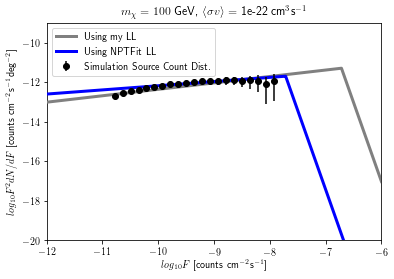

In [14]:
#best_fit_params[0] = 4.53908204
poisson = (trials==1)
yerr_up = (AssortedFunctions.PandGErrors(F_arr, poisson))[1][min_flux_ind:]
yerr_dn = (AssortedFunctions.PandGErrors(F_arr, poisson))[0][min_flux_ind:]
yerr_up = F**2 * yerr_up / dF /(4*np.pi*(180/np.pi)**2*area_rat)
yerr_dn = F**2 * yerr_dn / dF /(4*np.pi*(180/np.pi)**2*area_rat)
dNdF_err = (yerr_up + yerr_dn)/2.
delta_flux = max_flux - min_flux
exec(PowerLaw.genMinuitString( 1, "-14", "(-10,1000)", "1.", "0.01", "(-3., 3.)", "1e-3", "0.01", "(0., "+str(delta_flux)+")", ".1", fix_Fbfirst=str(max_flux), fix_nfirst="10.", vmin=min_flux, vmax=max_flux ));
minuit.migrad()
results = []
for val in minuit.values:
    results.append(minuit.values[val])
    
yerr_up = yerr_up/np.log(10) / (F**2 * dN/dF)
yerr_dn = yerr_dn/np.log(10) / (F**2 * dN/dF)
plt.errorbar(myLog(F), myLog(F**2*dN/dF), yerr=[yerr_up, yerr_dn], fmt='o', c="black", zorder=10, label="Simulation Source Count Dist.")
F_test = np.logspace(-12,6,5000)
plt.plot(myLog(F_test), 2*myLog(F_test)+PowerLaw.simple_power(myLog(F_test), False, *results), zorder=5, linewidth=3, c="grey", label="Using my LL") #$M_{min}=$1e-5, Broken power Law Fit, Nb = " +str(Nb))
plt.plot(myLog(F_test), 2*myLog(F_test)+PowerLaw.simple_power(myLog(F_test), False, *best_fit_params), zorder=5, linewidth=3, c="blue", label="Using NPTFit LL")
plt.xlim(-12, -6)
plt.ylim(-20, -9)
plt.title("$m_{\chi} = "+str(marr[0])+"$ GeV, $\\langle \sigma v \\rangle =$ "+str(xsec)+" cm$^3$s$^{-1}$")
plt.ylabel("$log_{10} F^2dN/dF$ [counts cm$^{-2}$s$^{-1}$deg$^{-2}$]")
plt.xlabel("$log_{10} F$ [counts cm$^{-2}$s$^{-1}$]")
plt.legend()
plt.show()
plt.close()

In [13]:
print(repr(F))
print(repr(F**2*dN/dF))

array([1.66009661e-11, 2.30669676e-11, 3.20514476e-11, 4.45353420e-11,
       6.18816570e-11, 8.59842837e-11, 1.19474775e-10, 1.66009661e-10,
       2.30669676e-10, 3.20514476e-10, 4.45353420e-10, 6.18816570e-10,
       8.59842837e-10, 1.19474775e-09, 1.66009661e-09, 2.30669676e-09,
       3.20514476e-09, 4.45353420e-09, 6.18816570e-09, 8.59842837e-09,
       1.19474775e-08, 1.66009661e-08, 2.30669676e-08, 3.20514476e-08,
       4.45353420e-08, 6.18816570e-08, 8.59842837e-08, 1.19474775e-07,
       1.66009661e-07, 2.30669676e-07, 3.20514476e-07, 4.45353420e-07,
       6.18816570e-07, 8.59842837e-07])
array([2.08258207e-13, 2.72476098e-13, 3.43385305e-13, 4.24117631e-13,
       5.09979407e-13, 5.90511740e-13, 6.89231258e-13, 7.75267779e-13,
       8.66009305e-13, 9.39173484e-13, 1.01951354e-12, 1.07662319e-12,
       1.10228858e-12, 1.20341966e-12, 1.21610632e-12, 1.26733069e-12,
       1.17396686e-12, 1.22341624e-12, 1.13328757e-12, 7.87348987e-13,
       1.09401787e-12, 1.52013290e-12

13.0


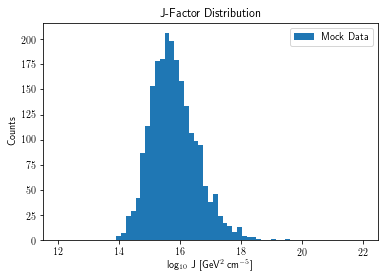

In [14]:
bins = plt.hist(np.log10(PS_set.J.value), bins=np.linspace(12,22,64), label="Mock Data")
plt.title("J-Factor Distribution")
plt.ylabel("Counts")
plt.xlabel("log$_{10}$ J [GeV$^2$ cm$^{-5}$]")
plt.legend()
print(np.sum(bins[0][bins[1][:-1]>18]))

/tigress/somalwar/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in log10
  # This is added back by InteractiveShellApp.init_path()


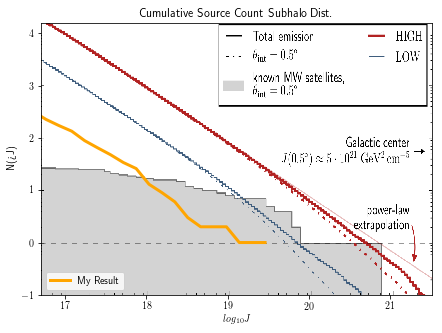

In [15]:
plt.figure(figsize=(7,5))
img = plt.imread("../PltImg/clumpy.png")
plt.imshow(img, extent=[16.7,21.51, -1,4.3], aspect='auto')

cum_J = []
N = np.sum(bins[0])
for J in bins[0]:
    cum_J.append(N)
    N -= J
#plt.plot(bins[1], 20.-bins[1], alpha=0.5)
plt.plot(bins[1][:-1], np.log10(cum_J), c="orange", linewidth=3, label="My Result")
plt.xlim(16.7, 21.51)
plt.ylim(-1,4.2)
plt.xlabel("$log_{10}J$")
plt.ylabel("N(>J)")
plt.title("Cumulative Source Count Subhalo Dist.")
plt.legend(loc=3)

Text(0.5,0,'Subhalo Mass [M$_{\\odot}$]')

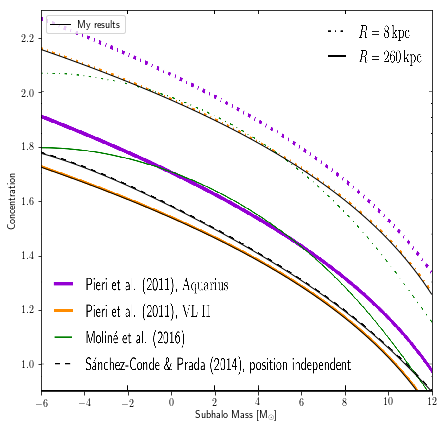

In [16]:
plt.figure(figsize=(7,7))
img = plt.imread("../PltImg/clumpy1.png")
plt.imshow(img, extent=[-6,12, myLog(8),myLog(200)], aspect='auto')

mass_test_arr = np.logspace(-6,12,1000)
plt.plot(myLog(mass_test_arr), myLog(PS_set.c200_SP(mass_test_arr*units.M_s, 1, 1)), c="black", linewidth=1, label="My results")
plt.plot(myLog(mass_test_arr), myLog(PS_set.c200_S(mass_test_arr*units.M_s, np.ones(1000)*260*units.kpc, 1)), c="black", linewidth=1)
plt.plot(myLog(mass_test_arr), myLog(PS_set.c200_S(mass_test_arr*units.M_s, np.ones(1000)*8*units.kpc, 1)), c="black", linewidth=1)
plt.ylim(myLog(8), myLog(200))
plt.xlim(-6, 12)
plt.legend(loc=2)
plt.ylabel("Concentration")
plt.xlabel("Subhalo Mass [M$_{\odot}$]")

In [17]:
r_test = np.logspace(-3, myLog(213.5*1.22), 1000)
r_hist = np.histogram(PS_set.Rvir, r_test*units.kpc);
N_cum = [0]
for ir, r in enumerate(r_test[:-1]):
    N_cum.append(N_cum[-1]+r_hist[0][ir])
N_cum = np.array(N_cum) / N_cum[np.argmin(np.abs(213.5-r_test))]

/tigress/somalwar/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log10
  """


(array(-2.30103), array(0.11394335))

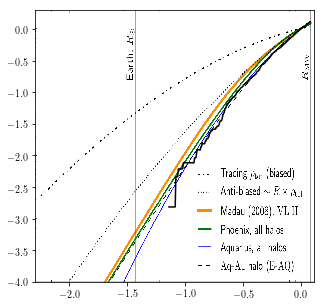

In [18]:
plt.figure(figsize=(5,5))
img = plt.imread("../PltImg/clumpy2.png")
plt.imshow(img, extent=[myLog(5e-3),myLog(1.5), -4,myLog(2)], aspect='auto')

plt.plot(myLog(r_test/213.5), np.log10(N_cum), c="black")
plt.ylim(-4, myLog(2))
plt.xlim(myLog(5e-3), myLog(1.3))

Text(0.5,1,'Earth-Subhalo Distance')

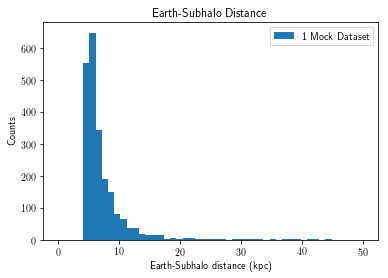

In [19]:
plt.hist(PS_set.r200/units.kpc, bins=np.linspace(0,50,50), label="1 Mock Dataset");
plt.xlabel("Earth-Subhalo distance (kpc)")
plt.ylabel("Counts")
plt.legend()
plt.title("Earth-Subhalo Distance")

Text(0.5,1,'Subhalo Mass')

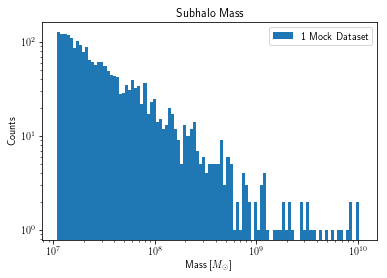

In [20]:
plt.hist(PS_set.Mvir/units.M_s, bins=np.logspace(myLog(mMin), myLog(mMax), 100), label="1 Mock Dataset")
plt.xscale("log")
plt.yscale("log")
plt.ylabel("Counts")
plt.xlabel("Mass [$M_{\odot}$]")
plt.legend()
plt.title("Subhalo Mass")

(0, 6.283185307179586)

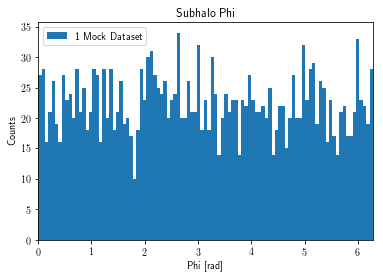

In [21]:
plt.hist(PS_set.phi, bins=np.linspace(0,2*np.pi,100), label="1 Mock Dataset")
plt.xlabel("Phi [rad]")
plt.ylabel("Counts")
plt.legend()
plt.title("Subhalo Phi")
plt.xlim(0,2*np.pi)

(0, 3.141592653589793)

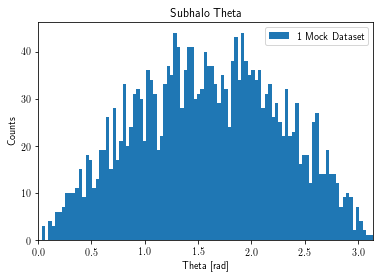

In [22]:
plt.hist(PS_set.theta, bins=np.linspace(0,np.pi,100), label="1 Mock Dataset")
plt.xlabel("Theta [rad]")
plt.ylabel("Counts")
plt.legend()
plt.title("Subhalo Theta")
plt.xlim(0,np.pi)

Text(0.5,1,'GC-Subhalo Radius')

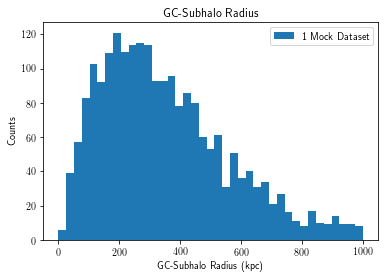

In [23]:
plt.hist(PS_set.Rvir/units.kpc, bins=np.linspace(0,1000,40), label="1 Mock Dataset");
plt.xlabel("GC-Subhalo Radius (kpc)")
plt.ylabel("Counts")
plt.legend()
plt.title("GC-Subhalo Radius")

In [24]:
for iP, PS_set in tqdm_notebook(enumerate(PS_arr)):
    flux_map = np.zeros(hp.nside2npix(nside))
    flux = PS_set.J.value * xsec * PPnoxsec
    for ipix, pix in enumerate(PS_set.pixels):
        flux_map[pix] += flux[ipix]
    np.save("MC/subhalo2_flux_map"+str(iP), flux_map)
    #np.save("MC/flux_arr"+str(iP), flux)

In [31]:
flux_map = np.zeros(hp.nside2npix(nside))
for iP, PS_set in tqdm_notebook(enumerate(PS_arr)):
    flux = PS_set.J.value * xsec * PPnoxsec
    for ipix, pix in enumerate(PS_set.pixels):
        flux_map[pix] += flux[ipix]/trials
np.save("MC/subhalo_flux_map_ave"+str(iP), flux_map)